## 2. Outlier detection

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Introduction

For this part, we will be doing outlier detection on a new datset that uses Fashion-MNIST dataset. The original dataset contains images of Zalando's articles in 28X28 pixels grayscale images. In the modified version, we will be using a small sample of the dataset which has additional outliers added to it. The dataset is provided in a file named "fmnist_710.npz". Each image is a representation of a fashion item.

### Objective

The main objective is to use various techniques such as PCA, K-means clustering, t-Distributed Stochastic Neighbor Embedding and compare the performance of each model. This is a classification problem using image classficiation.

### 2.1 Exploratory Data Analysis (EDA)

For exploratory data analysis, we start by loading the dataset from the file 'fmnist_710.npz'. We also divide the data into images and labels. From the initial exploration, we can see that there are 10 different classes and a total of 1210 images. Furthermore, we see different images for each class to understand how our dataset actually looks like. Each class is a different fashion item. The different classes include tshirt/top, trouser, pullover, dress, coat, sandal, shirt, sneaker, bag and ankle boot. 

In [43]:
data = np.load('fmnist_710.npz')
images, labels  = data['x'] , data['y']

#### Number of classes and images

In [44]:
# Number of unique classes
num_classes = len(np.unique(labels))
print(f"Number of classes: {num_classes}")

# Number of images
num_images = len(images)
print(f"Number of images: {num_images}")


Number of classes: 10
Number of images: 1210


#### Sample images in the dataset for each class

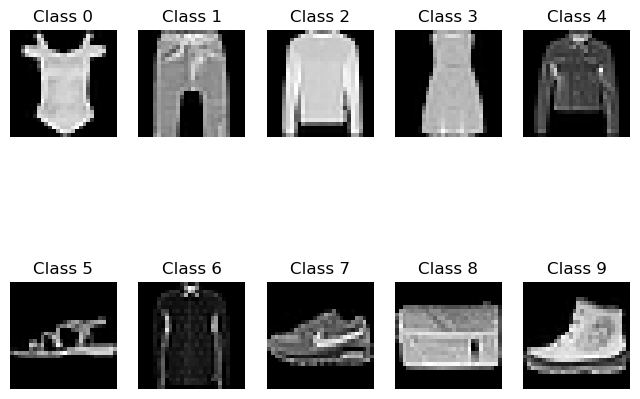

In [45]:
plt.figure(figsize=(8, 6))

# Show one image for each of the 10 different classes
for class_label in range(10):
    class_indices = np.where(labels == class_label)[0]
    
    image_index = class_indices[0]

    plt.subplot(2, 5, class_label + 1)
    plt.imshow(images[image_index], cmap='gray')
    plt.title(f"Class {class_label}")
    plt.axis('off')

plt.show()


#### Different classes in the dataset

In [42]:
import pandas as pd
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

df = pd.DataFrame({'Labels': classes})

print(df)


        Labels
0  T-shirt/top
1      Trouser
2     Pullover
3        Dress
4         Coat
5       Sandal
6        Shirt
7      Sneaker
8          Bag
9   Ankle boot


#### Checking for missing data

In [29]:
# Check for missing data
missing_values = np.isnan(images).sum()
print(f"Number of missing values: {missing_values}")

Number of missing values: 0


There are no missing values in the dataset.

#### Distribution of different labels

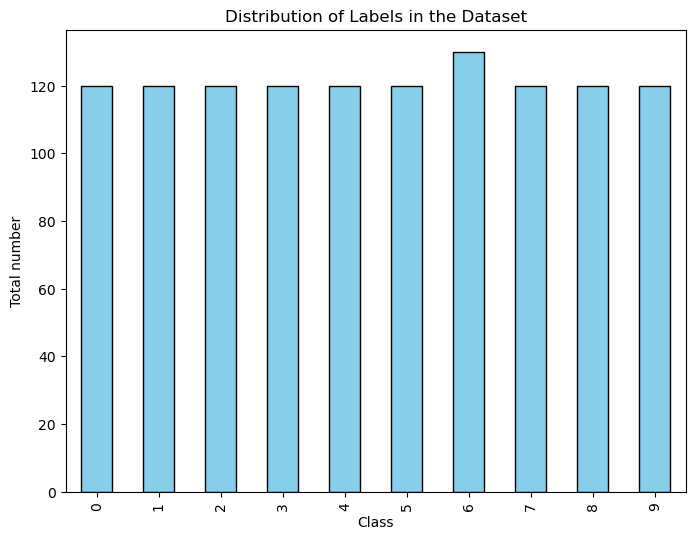

In [51]:
labels_series = pd.Series(labels)
class_counts = labels_series.value_counts()

# Bar plot
plt.figure(figsize=(8, 6))
class_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Labels in the Dataset')
plt.xlabel('Class')
plt.ylabel('Total number')
plt.show()

It can be seen through the distribution that the dataset has different labels more or less equally distributed. However, label 6 - shirt seems to have slightly higher number than the rest.

#### Normalization

In [46]:
#Normalizing the pixel between 0 and 1
train_images = images.astype('float32') / 255

# Flatten images
X = train_images.reshape((train_images.shape[0], -1))

We are normalizing the images in order to bring all images to similar scale. This allows for speed up the training process as well as prevents one image to dominate the model. Additionally, flattening step allows to change two dimensional images into one dimension. This is an essential step before using the dataset on a machine learning model.

### 2.2 PCA for Dimensionality Reduction

PCA also known as Principal Component Analysis, is used to reduce dimensionality while also preserving most important information. Firstly, we will reduce the principal components to 2. We also calculate reconstruction error which suggests the difference between original data and reconstructed data. The outlier PCA is used to detect outliers from the threshold set at 95 which means data points higher than 95th percentile of recontruction error are considered outliers.

In [174]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error_pca = np.sum((X - X_reconstructed) ** 2, axis=1)
outliers_pca = reconstruction_error_pca > np.percentile(reconstruction_error_pca, 95)

msre= np.mean ((X - X_reconstructed)**2)
print(f"Mean Squared Reconstruction Error: {msre}")

Mean Squared Reconstruction Error: 0.0461566224694252


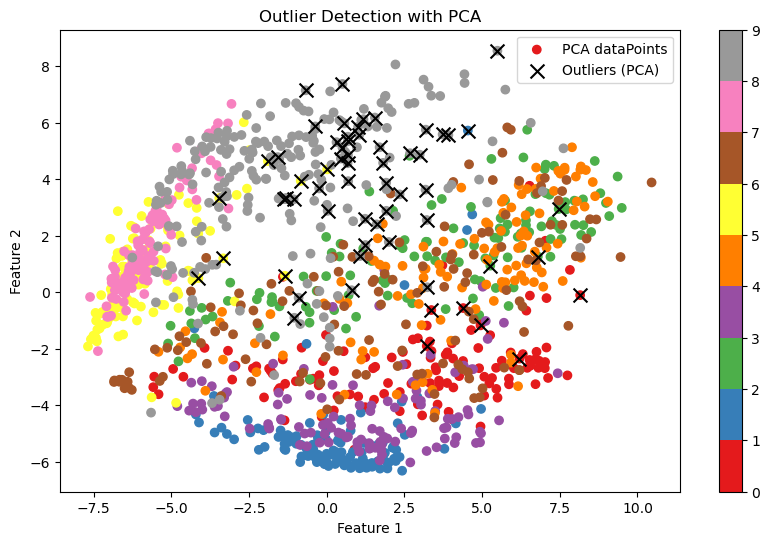

In [162]:
plt.figure(figsize=(10, 6))
p = plt.scatter(X_pca[:, 0], X_pca[:, 1],  c=labels, label='PCA dataPoints', cmap='Set1')
plt.scatter(X_pca[outliers_pca, 0], X_pca[outliers_pca, 1], c='k', marker='x', s=100,label='Outliers (PCA)')
plt.title('Outlier Detection with PCA')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
cbar = plt.colorbar(p, orientation='vertical' )
plt.legend()


The plot shows different data points in the reconstructed two feature components. The colors represent different class label as shown by the legend. The X represents outliers beyond the threshold set. The outliers are concerntrated in a specific area where there are lighter colors indicating higher number labels such as 8 or 9. 

Text(0.5, 0.98, 'All Outliers Detected through PCA')

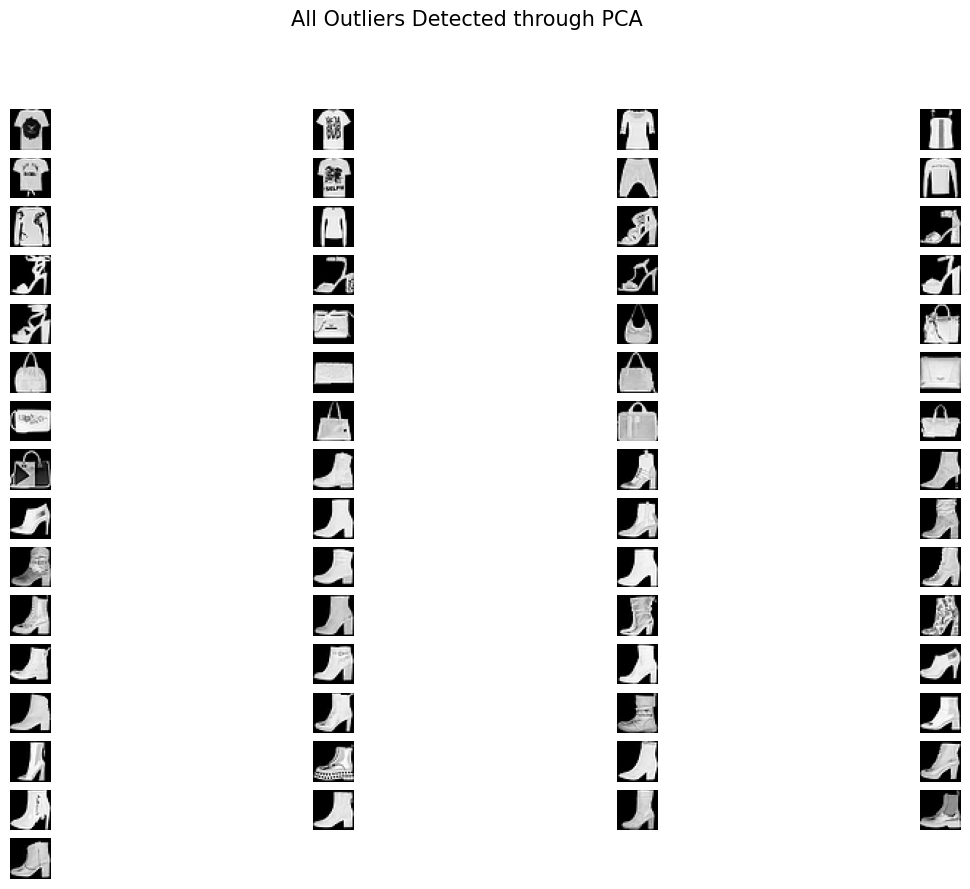

In [84]:
outlier_indices = np.where(outliers_pca)[0]

# Outliers detected through PCA
plt.figure(figsize=(15, 10))
num_outliers = len(outlier_indices)
num_rows = num_outliers // 4 + (num_outliers % 4 > 0) 

for i, idx in enumerate(outlier_indices):
    plt.subplot(num_rows, 4, i + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.axis('off')
plt.suptitle('All Outliers Detected through PCA', fontsize=15)


As analyzed based on previous scatter plot, the outliers seem to lie in label 8 or 9 which are bag or ankle boots.

### 2.3 K-means Clustering

K-means clustering is an unsupervised machine learning technique, that converts data into k-clusters and groups similar datapoints together. It detects outliers by checking clusters that deviate from the nearest mean. We will start by deciding what number of cluster might be optimal for this technique.

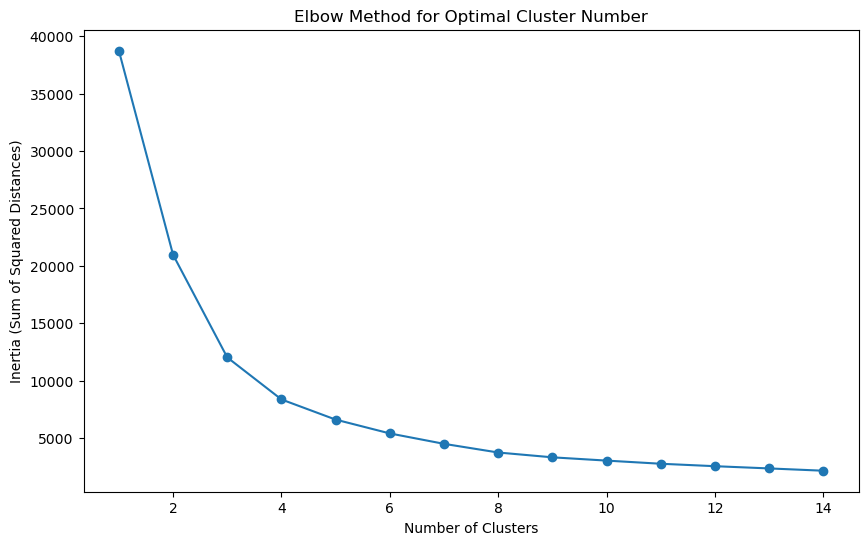

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Checking different cluster range
inertia_values = []
cluster_range = range(1, 15)

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters,  n_init=10, random_state=40)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

# Elbow method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.show()

Based on the elbow method, we can choose the optimal number of cluster where the inertia slows down. As shown in the graph, the optimal cluster seems to be at 5. 

In [142]:
import numpy as np
from sklearn.cluster import KMeans

num_clusters = 5

# K-means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
kmeans.fit(X_pca)
cluster_labels = kmeans.fit_predict(X_pca)

# Access cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate distances to cluster centers
distances = np.zeros(X_pca.shape[0])

for i in range(num_clusters):
    cluster_points = X_pca[cluster_labels == i]
    cluster_center = cluster_centers[i]
    cluster_distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
    distances[cluster_labels == i] = cluster_distances

# Identify potential outliers
outlier_threshold = np.percentile(distances, 95)
potential_outliers = np.where(distances > outlier_threshold)[0]

num_outliers = len(potential_outliers)

print(f"Number of outliers: {num_outliers}")

Number of outliers: 61


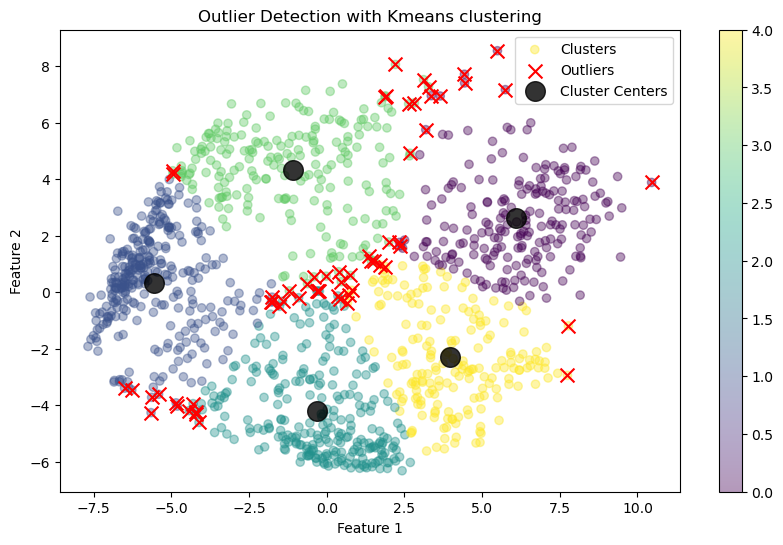

In [148]:
plt.figure(figsize=(10, 6))

# Plot each cluster
p = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, label='Clusters', cmap='viridis', alpha=0.4)

# Plot outliers
plt.scatter(X_pca[potential_outliers, 0], X_pca[potential_outliers, 1], c='red', marker='x', s=100, label='Outliers')


plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', marker='o', s=200, alpha=0.8, label='Cluster Centers')

plt.title('Outlier Detection with K-means clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
cbar = plt.colorbar(p, orientation='vertical')
plt.legend()
plt.show()

The plot shows the distribution of different clusters and outliers. The centers show the center of mass for data points in each cluster. The outliers marked X shows data points that have distances beyond the threshold. Overall, it shows how 61 outliers are spread across different clusters.

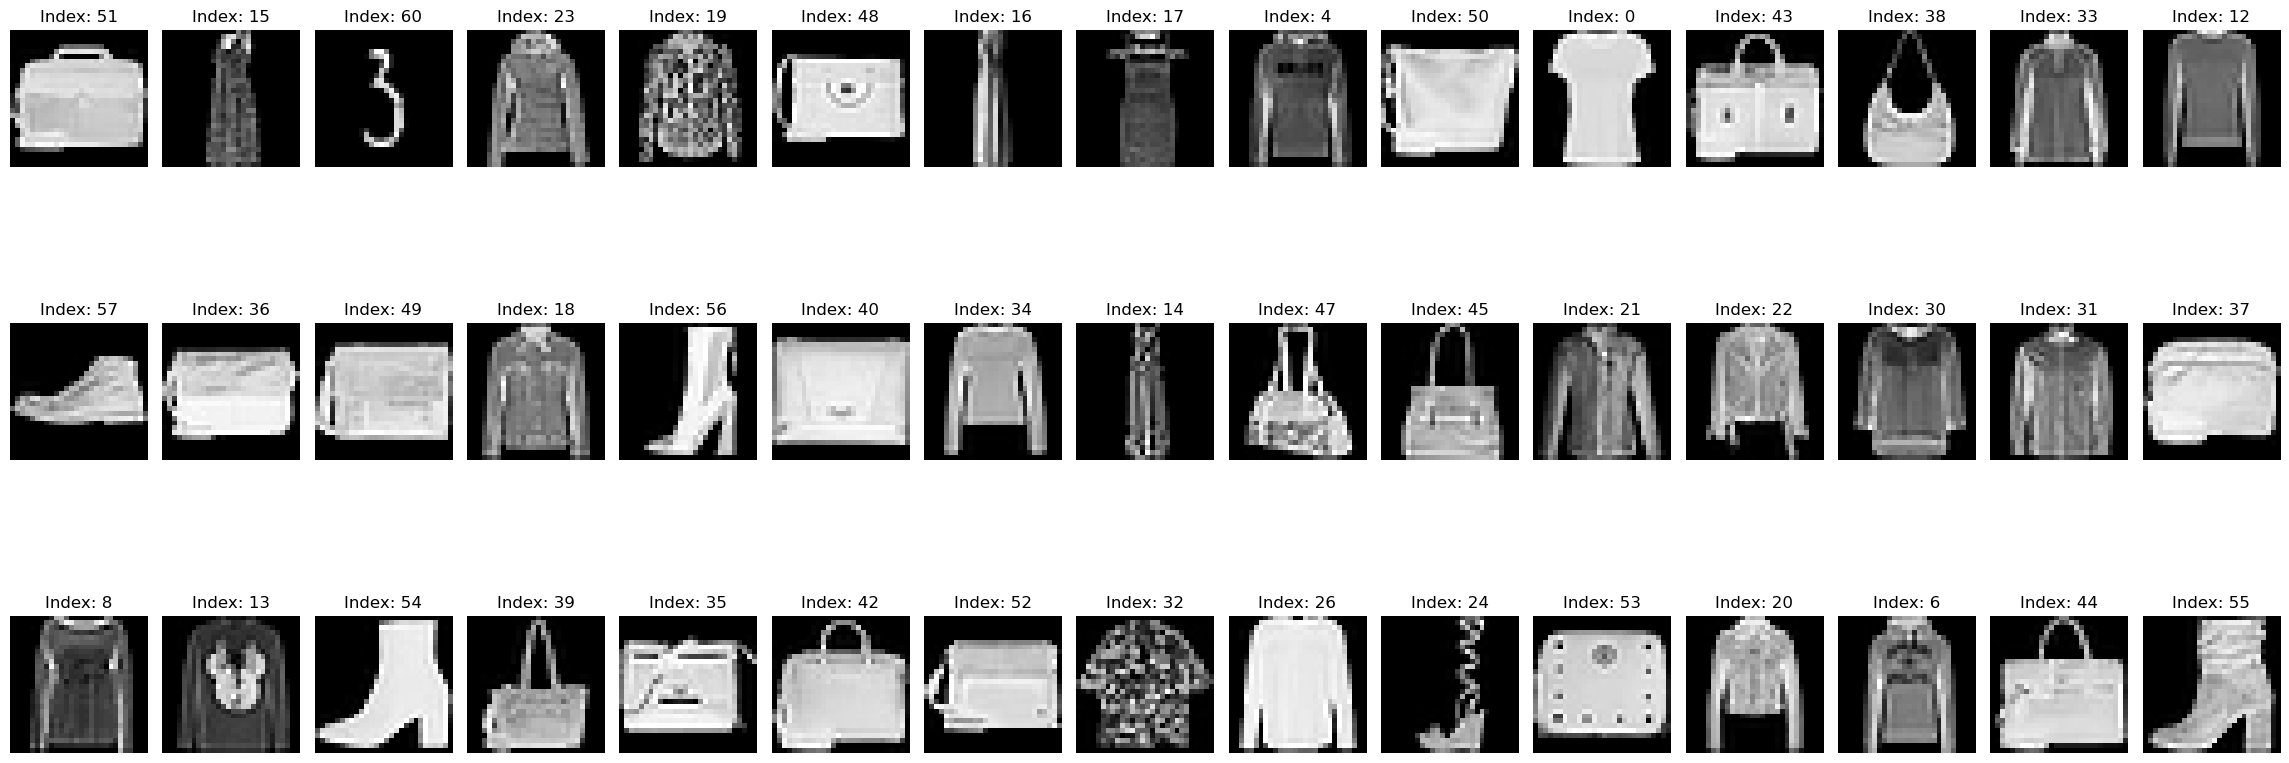

In [153]:
img = X[potential_outliers]
indx = np.random.choice(range(img.shape[0]) , 45, replace =False)
plt.figure(figsize=(23, 10))
for i, idx in enumerate(indx):
    plt.subplot(3, 15, i + 1)
    plt.imshow(img[idx].reshape(28,28), cmap='gray')
    plt.title(f"Index: {idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

The above images show outliers detected by Kmeans clustering which is 1 out of a sample of 45.

#### Performance Evaluation

In [170]:
from sklearn.metrics import silhouette_score

silhouette_score = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.43016135692596436


Silhouette Score is used to determine the goodness of clustering technique. It shows how well the clusters are separated into groups. In this case, the score is 0.43 which is shows an average clustering performance where the clusters might be towards their boundary. It can also be due to high overlapping of cluster. 

### 2.4 t-SNE for Visualization

t-Distributed Stochastic Neighbor Embedding (t-SNE) is used to reduce dimensionality by converting high dimension data into lower dimension spaces. It allows to analyze complex relationships. It is useful for non linear relationship where it tries to preserve pairwise similarities between data points.

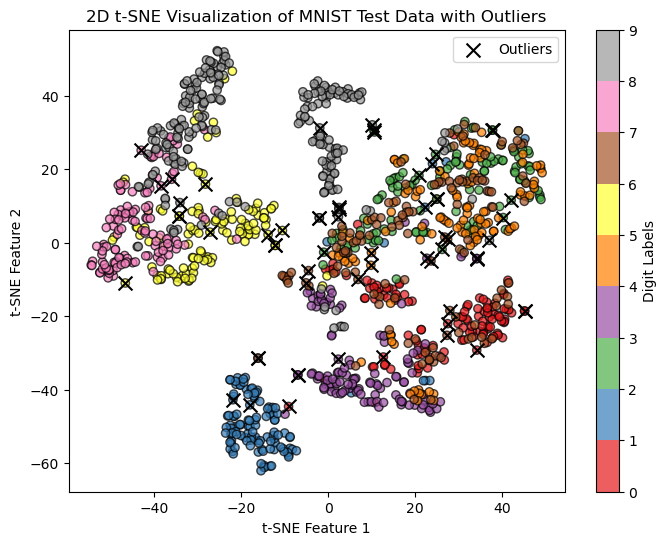

In [163]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, 
            perplexity=15,
            n_iter=1000, random_state=42)

X_tsne = tsne.fit_transform(X)  # Using a subset for quicker execution



# Outlier Detection: Calculate the distance from each point to its neighbors
distances = np.sqrt(((X_tsne[:, np.newaxis, :] - X_tsne[np.newaxis, :, :]) ** 2).sum(axis=2)) # computes the distance between each pair 
k_nearest_distances = np.sort(distances, axis=1)[:, 1:6]  # selects the distances to the five nearest points (excluding the distance to the point itself, which is zero).
outlier_scores = k_nearest_distances.mean(axis=1) #The mean distance to these nearest point
outliers = outlier_scores > np.percentile(outlier_scores, 95)  # Top 5% as outliers

# 2D Visualization of t-SNE results with Outliers
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels,
            cmap='Set1',
            edgecolor='k', alpha=0.7)
plt.scatter(X_tsne[outliers, 0], X_tsne[outliers, 1], c='k', marker='x', s=100, label='Outliers')
plt.title('2D t-SNE Visualization of MNIST Test Data with Outliers')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(scatter, label='Digit Labels')
plt.legend()
plt.show()


The plot showcases the use of t-SNE to transform high dimensionality data into 2D visualization. t-SNE aims to protect local relationship between data points. Hence, it tries to preserve pairwise similarities. The distance between each point and its five nearest neighbours are calculated, and the mean distance is used as a basis for outlier score. The outliers shown by X are determined by top 5% scores based on percentile. These outliers deviate significantly from the local structures, hence showing unusual patterns.

### 2.5 Comparative Analysis

In [176]:
performance = pd.DataFrame({
 'Model': ['PCA', 'K-Means'],
 'Mean Squared Reconstruction Error':[msre, np.nan],
 'Silhouette Score':[np.nan, silhouette_score]
})

performance

,Model,Mean Squared Reconstruction Error,Silhouette Score
0,PCA,0.046157,NaN
1,K-Means,NaN,0.430161


There are several distinctions on how each model analyzes outliers. We started with PCA which is used for dimensionality reduction and helps to preserve information in reconstructed features. The mean squared reconstruction error suggests the difference between original and new reconstructed output. A low MSRE suggests a better model performance by reconstructed features. In this case, MSRE is 0.046 which means the model was able to preserve much information from original data points and performed similar to original data point. It calculates outliers based on high reconstruction error. However, PCA might not be best for high dimensionality dataset. 

We also used K-means clustering technique. This is an unsupervised machine learning method. This method is used to find similarities in dataset and combine them into cluster. Outliers are determined if they are further away from cluster center or don't match the general characteristics of the cluster they belong to. It is a scalable method which can be adapted to larger datasets. The most important thing in K-means clustering is determining the number of cluster which can affect performance. The Silhouette Score suggests the performance of K-means clustering. The value 0.43 suggests an average performance in clustering the dataset. It doesn't show a great performance; however, its not poor either. 

t-SNE is perfect for non linear and high dimensional dataset. It also uses 2D visualization tool to identify outliers which are further away from the cluster. However, t-SNE is highly complex and need high computational power. 

Overall, PCA and K-mean clustering identify outliers based on distance from cluster or reconstruction error. t-SNE identifies outliers based on points far from clusters in t-SNE space. 

Based on the above calculation, it shows a strong performance of PCA in dimensionality reduction and having a very low mean squared reconstruction error.